In [1]:
import numpy as np
import pandas as pd
from matplotlib import  pyplot as plt
import math as m
import scipy.stats as sts
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [104]:
import matplotlib.ticker as ticker
import datetime

In [2]:
data = pd.read_csv("ebola_2014_2016_clean.csv")

In [8]:
data.shape

(2485, 10)

In [11]:
data.head()

,Country,Date,No. of suspected cases,No. of probable cases,No. of confirmed cases,"No. of confirmed, probable and suspected cases",No. of suspected deaths,No. of probable deaths,No. of confirmed deaths,"No. of confirmed, probable and suspected deaths"
0,Guinea,2014-08-29,25.0,141.0,482.0,648.0,2.0,141.0,287.0,430.0
1,Nigeria,2014-08-29,3.0,1.0,15.0,19.0,0.0,1.0,6.0,7.0
2,Sierra Leone,2014-08-29,54.0,37.0,935.0,1026.0,8.0,34.0,380.0,422.0
3,Liberia,2014-08-29,382.0,674.0,322.0,1378.0,168.0,301.0,225.0,694.0
4,Sierra Leone,2014-09-05,78.0,37.0,1146.0,1261.0,11.0,37.0,443.0,491.0


In [9]:
countries = data["Country"].unique()
countries.shape

(10,)

In [34]:
countries

array(['Guinea', 'Nigeria', 'Sierra Leone', 'Liberia', 'Senegal',
       'United States of America', 'Spain', 'Mali', 'United Kingdom',
       'Italy'], dtype=object)

In [13]:
data.drop_duplicates(inplace=True)

In [37]:
deaths = [(country,data[data["Country"] == country]["No. of confirmed deaths"].sum()) for country in countries]

In [41]:
deaths.sort(key=lambda i: -i[1])

In [42]:
deaths

[('Sierra Leone', 797984.0),
 ('Guinea', 461211.0),
 ('Liberia', 26937.0),
 ('Nigeria', 1784.0),
 ('United States of America', 242.0),
 ('Mali', 21.0),
 ('Senegal', 0.0),
 ('Spain', 0.0),
 ('United Kingdom', 0.0),
 ('Italy', 0.0)]

In [220]:
main_countries = deaths[:2]
additional_countries = deaths[2:6]

In [221]:
main_countries

[('Sierra Leone', 797984.0), ('Guinea', 461211.0)]

In [222]:
additional_countries

[('Liberia', 26937.0),
 ('Nigeria', 1784.0),
 ('United States of America', 242.0),
 ('Mali', 21.0)]

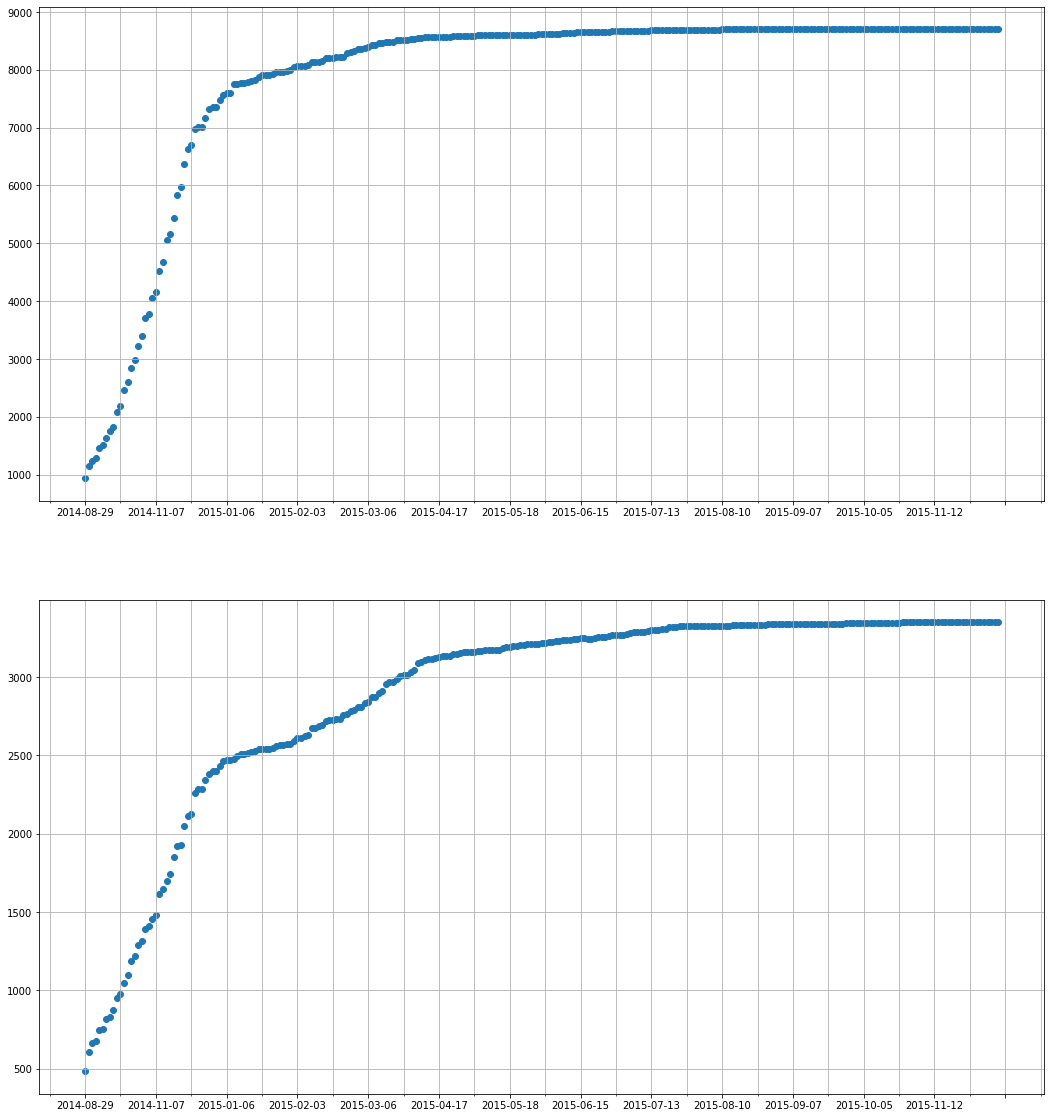

In [224]:
fig, ax = plt.subplots(2, figsize=(18, 20))
for idx, country in enumerate(main_countries):
    stat = data[data["Country"] == country[0]][["Date", "No. of confirmed cases"]]
    stat.dropna(inplace=True)
    ax[idx].scatter(stat['Date'], stat["No. of confirmed cases"])
    
    ax[idx].xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax[idx].xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax[idx].grid(which='both')
plt.show()

In [122]:
def goal_f(X, a, b):
    res = []
    for x in X:
        res.append((1/(1 + m.exp(-b*((datetime.datetime.strptime(x, "%Y-%m-%d") - datetime.datetime(2014,8,9)).total_seconds()))) - 0.5) * a )
    return np.array(res)

In [202]:
A = np.linspace(100, 20000, 30)
B = np.linspace(0.000001, 0.00000001, 30)

In [212]:
def error(X, a, b, y):
    y = np.array(y)
    pred = goal_f(X,a,b)
    delta = pred - y
    return (delta * delta).sum()

In [225]:
best_params = []
for country in main_countries:
    err = []
    stat = data[data["Country"] ==  country[0]][["Date", "No. of confirmed cases"]]
    for a in A:
        for b in B:
            err.append((a, b, error(stat['Date'], a, b, stat["No. of confirmed cases"])))
    err.sort(key=lambda i: i[2])
    best_params.append((country[0], err[0][0], err[0][1]))
    
best_params

[('Sierra Leone', 17255.172413793105, 1.8068965517241364e-07),
 ('Guinea', 6962.068965517242, 1.4655172413793085e-07)]

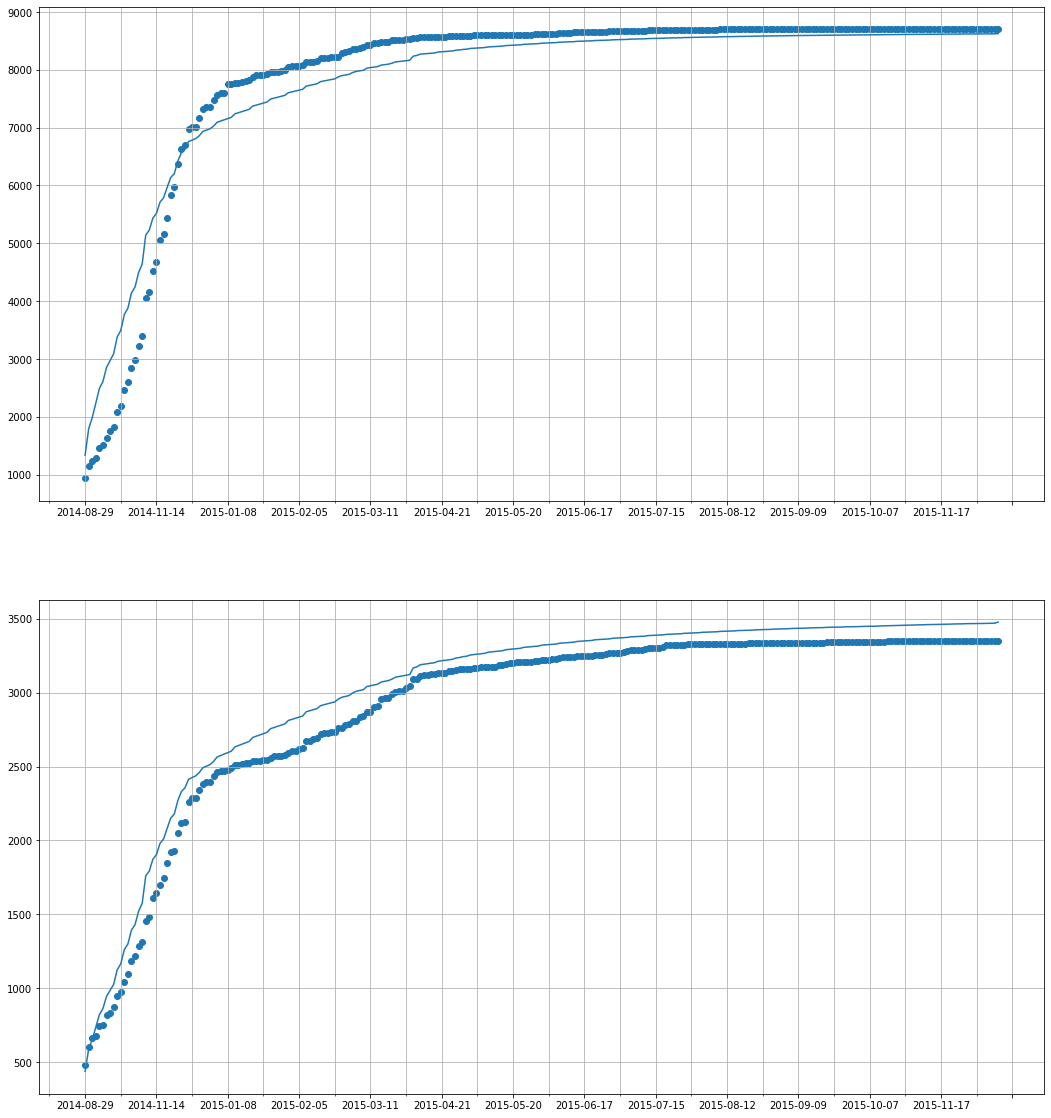

In [233]:
fig, ax = plt.subplots(2, figsize=(18, 20))
for idx, country in enumerate(best_params):
    stat = data[data["Country"] == country[0]][["Date", "No. of confirmed cases", "No. of confirmed deaths"]]
    stat.dropna(inplace=True)
    ax[idx].scatter(stat['Date'], np.array(stat["No. of confirmed cases"]))
    ax[idx].plot(stat['Date'], goal_f(stat['Date'], country[1], country[2]))
    ax[idx].xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax[idx].xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax[idx].grid(which='both')
    
plt.show()

In [259]:
A_attit = np.linspace(1,100,30)
B_attit = np.linspace(0.00001, 0.000001, 30)

In [263]:
def goal_f_attit(X, a, b, shift):
    res = []
    for x in X:
        delta = (datetime.datetime.strptime(x, "%Y-%m-%d") - datetime.datetime.strptime(shift, "%Y-%m-%d")).total_seconds()
        if delta > 0:
            res.append((1/(1 + m.exp(-b*(delta))) - 0.5) * a )
    return np.array(res)

In [269]:
def error_attit(X, a, b, y, shift):
    y = np.array(y)
    pred = goal_f_attit(X,a,b, shift)
    delta = pred - y[-pred.size:]
    return (delta * delta).sum()

In [270]:
best_params_attit = []
for country in main_countries:
    err = []
    stat = data[data["Country"] == country[0]][["Date", "No. of confirmed cases", "No. of confirmed deaths"]]
    stat.dropna(inplace=True)
    percentage = zip(stat['Date'], np.array(stat["No. of confirmed deaths"]).cumsum() / np.array(stat["No. of confirmed cases"]).cumsum() * 100)
    minim = 100;
    date_for_min = 0
    for elem in percentage:
        if minim  > elem[1]:
            minim = elem[1]
            date_for_min = elem[0]
    for a in A_attit:
        for b in B_attit:
            err.append((a, b, error_attit(stat['Date'], a, b, stat["No. of confirmed cases"], date_for_min)))
    err.sort(key=lambda i: i[2])
    best_params_attit.append((country[0], err[0][0], err[0][1], date_for_min))
    
best_params_attit

[('Sierra Leone', 100.0, 1e-05, '2014-12-10'),
 ('Guinea', 100.0, 1e-05, '2014-10-25')]

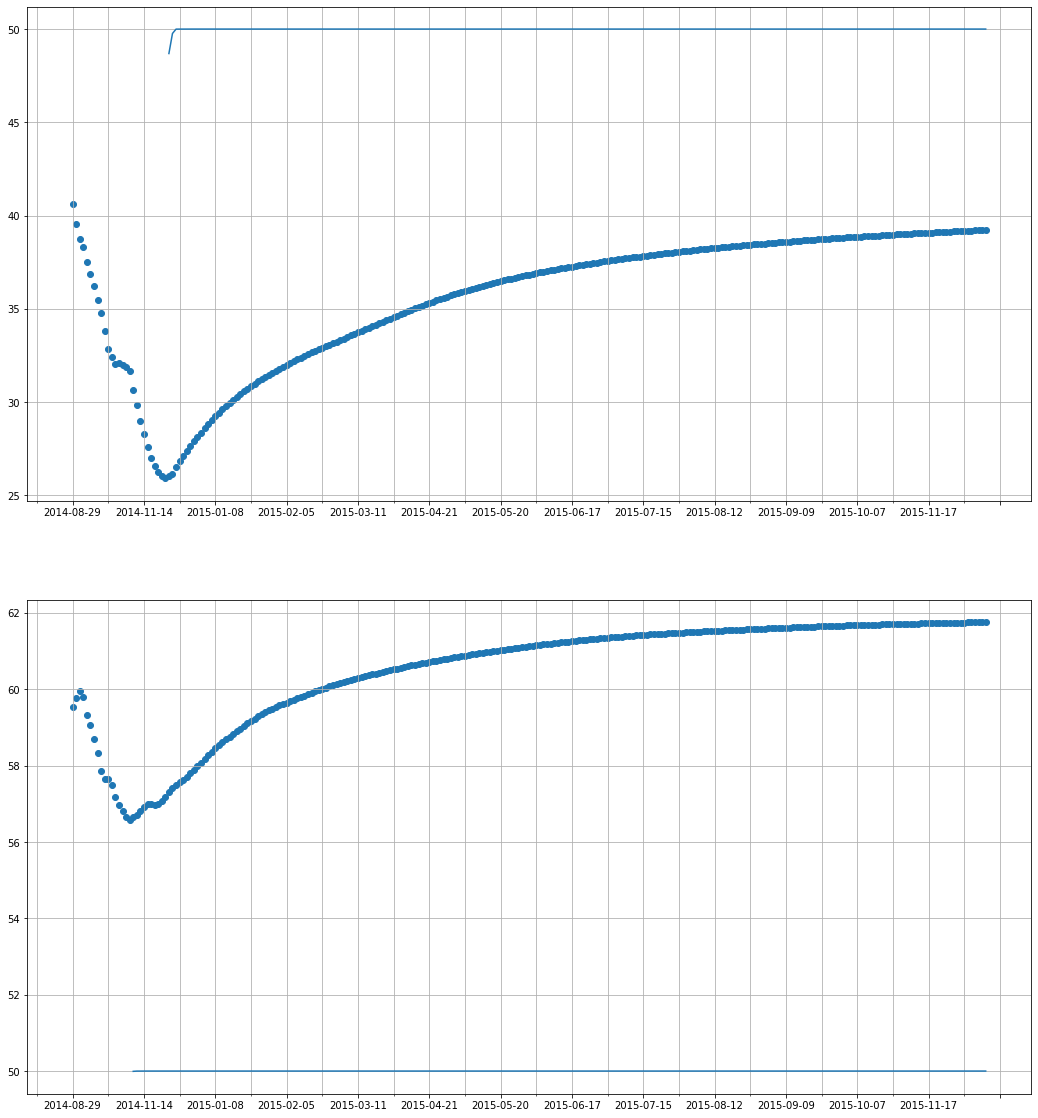

In [272]:
fig, ax = plt.subplots(2, figsize=(18, 20))
for idx, country in enumerate(best_params_attit):
    stat = data[data["Country"] == country[0]][["Date", "No. of confirmed cases", "No. of confirmed deaths"]]
    stat.dropna(inplace=True)
    percentage = np.array(stat["No. of confirmed deaths"]).cumsum() / np.array(stat["No. of confirmed cases"]).cumsum() * 100   
    ax[idx].scatter(stat['Date'], percentage)
    predict = goal_f_attit(stat['Date'], country[1], country[2], country[3])
    ax[idx].plot(np.array(stat['Date'])[-predict.size:], predict)
    ax[idx].xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax[idx].xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax[idx].grid(which='both')
    
plt.show()